## Problem 1: Data Acquisition and Analysis
Using reported crime data from the Chicago Open Data Portal for 2017 and 2018, this section summarizes the total number of crimes of each type, how they change over time (i.e., from 2017 to 2018), and how they differ by neighborhood. 

In [1]:
import pandas as pd 
import geopandas as gpd
from sodapy import Socrata
import censusdata
from shapely.geometry import Point
import matplotlib.pyplot as plt
import warnings

In [2]:
# Load crime data 
token = 'jPxpmCSNJQiUeytNCR63p768s' 
client = Socrata('data.cityofchicago.org', token)
results = client.get('6zsd-86xi', where='year in (2017, 2018)', limit=9999999) 
crime_df = pd.DataFrame.from_records(results)

# Convert to geodata frame 
crime_df[['latitude', 'longitude']] = crime_df[['latitude', 'longitude']].apply(pd.to_numeric) 
crime_df['coordinates'] = list(zip(crime_df['longitude'], crime_df['latitude']))
crime_df['coordinates'] = crime_df['coordinates'].apply(Point)
crime_gdf = gpd.GeoDataFrame(crime_df, geometry='coordinates')
crime_gdf.dropna(subset=['location'], inplace=True)

The table below shows the number of crimes of each type in 2017 and 2018, along with the combination of the two years and the difference between the years. Theft, battery, and criminal damage were the three most frequently reported crimes across both years. The top 20 most common crimes are shown. 

In [3]:
# Create summary table by type
by_type = crime_df.groupby(['primary_type', 'year']).size().unstack(fill_value=0)
by_type['combined'] = by_type['2017'] + by_type['2018']
by_type['difference'] = by_type['2018'] - by_type['2017']
by_type = by_type.sort_values(by=['combined'], ascending=False).reset_index(col_level=1)
by_type['pct_change'] = by_type['difference'] / by_type['2017']
by_type[:20]

year,primary_type,2017,2018,combined,difference,pct_change
0,THEFT,64346,65082,129428,736,0.011438
1,BATTERY,49214,49781,98995,567,0.011521
2,CRIMINAL DAMAGE,29042,27806,56848,-1236,-0.042559
3,ASSAULT,19303,20377,39680,1074,0.055639
4,DECEPTIVE PRACTICE,19028,18736,37764,-292,-0.015346
5,OTHER OFFENSE,17227,17130,34357,-97,-0.005631
6,BURGLARY,13000,11730,24730,-1270,-0.097692
7,NARCOTICS,11658,12988,24646,1330,0.114085
8,ROBBERY,11877,9682,21559,-2195,-0.184811
9,MOTOR VEHICLE THEFT,11406,9988,21394,-1418,-0.124321


The following three figures visualize this data. The first figure shows the total number of crimes of each type aggregated across 2017 and 2018. The second figure shows this data broken out by each year. The third figure shows the difference between reported crimes of each type between 2017 and 2018 (with positive values indicating that the number of crimes of that particular type rose between 2017 and 2018). Reports of narcotics, assault, and weapons violation saw the largest increase, while robbery, motor vehicle theft, and burglary saw the largest decrease. 

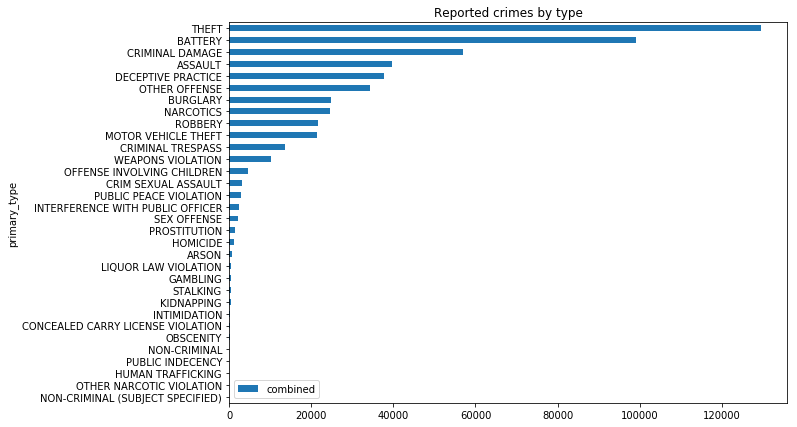

In [4]:
# Create figure for combined crimes by type
by_type = by_type.sort_values(by=['combined'])
by_type.plot.barh(x='primary_type', y='combined', figsize=(10, 7), 
                  title='Reported crimes by type')

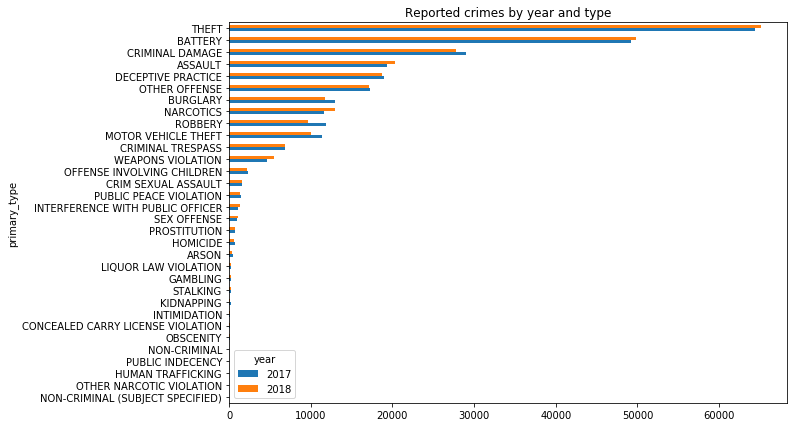

In [5]:
# Create figure for crimes by type for each year
by_type = by_type.sort_values(by=['combined'])
by_type.plot.barh(x='primary_type', y=['2017', '2018'], figsize=(10, 7), 
                 title='Reported crimes by year and type')

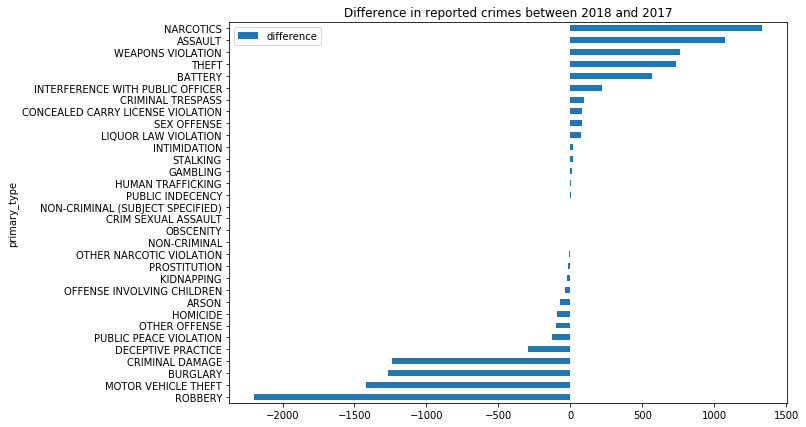

In [6]:
# Create figure for change (2018-2017) by type
by_type = by_type.sort_values(by=['difference'])
by_type.plot.barh(x='primary_type', y='difference', figsize=(10, 7), 
                 title='Difference in reported crimes between 2018 and 2017')

In [7]:
# Load neighborhood geodata 
url = 'https://data.cityofchicago.org/resource/y6yq-dbs2.geojson'
neighborhood_gdf = gpd.read_file(url)
neighborhood_gdf.head()

# Join crime and neighborhood geodata 
crime_gdf.crs = neighborhood_gdf.crs
crime_neighborhood = gpd.sjoin(crime_gdf, neighborhood_gdf, how="left", op='within')

The table below shows the number of reported crimes in 2017 and 2018 broken out by neighborhood, again, with the combination of the two years and the difference between the years. South Shore/Grand Crossing, Austin, and Englewood saw the highest number of reported crimes across both years. Only top 20 neighborhoods are shown.

In [8]:
# Create summary table for crimes by neighborhood
by_neighborhood = crime_neighborhood.groupby(['sec_neigh', 'year']).size().unstack(fill_value=0)
by_neighborhood['combined'] = by_neighborhood['2017'] + by_neighborhood['2018']
by_neighborhood['difference'] = by_neighborhood['2018'] - by_neighborhood['2017']
by_neighborhood = by_neighborhood.sort_values(by=['combined'], ascending=False).reset_index()
by_neighborhood['pct_change'] = by_neighborhood['difference'] / by_neighborhood['2017']
by_neighborhood[:20]

year,sec_neigh,2017,2018,combined,difference,pct_change
0,"SOUTH SHORE, GRAND CROSSING",14827,14803,29630,-24,-0.001619
1,AUSTIN,14515,14278,28793,-237,-0.016328
2,ENGLEWOOD,12985,13422,26407,437,0.033654
3,GARFIELD PARK,10066,10512,20578,446,0.044308
4,"WASHINGTON HEIGHTS,ROSELAND",9933,10024,19957,91,0.009161
5,HUMBOLDT PARK,9424,9248,18672,-176,-0.018676
6,LOOP,9103,9459,18562,356,0.039108
7,NORTH LAWNDALE,8962,9224,18186,262,0.029235
8,"MARQUETTE PARK,GAGE PARK",7990,7691,15681,-299,-0.037422
9,AUBURN GRESHAM,7701,7529,15230,-172,-0.022335


The following three figures parallel the above three figues– but, here, showing how reported crimes vary across neighborhoods, rather than by type. The first figure shows the total number of crimes of each type aggregated across 2017 and 2018. The second figure shows this data broken out by each year. The third figure shows the difference between reported crimes of each type between 2017 and 2018 (with positive values indicating that the number of crimes of that particular type rose between 2017 and 2018). Garfield Park, Englewood, and Old Town saw the largest increase in reported crimes, while Wicker Park/West Town, Back of the Yards, and Woodlawn saw the largest decrease. 

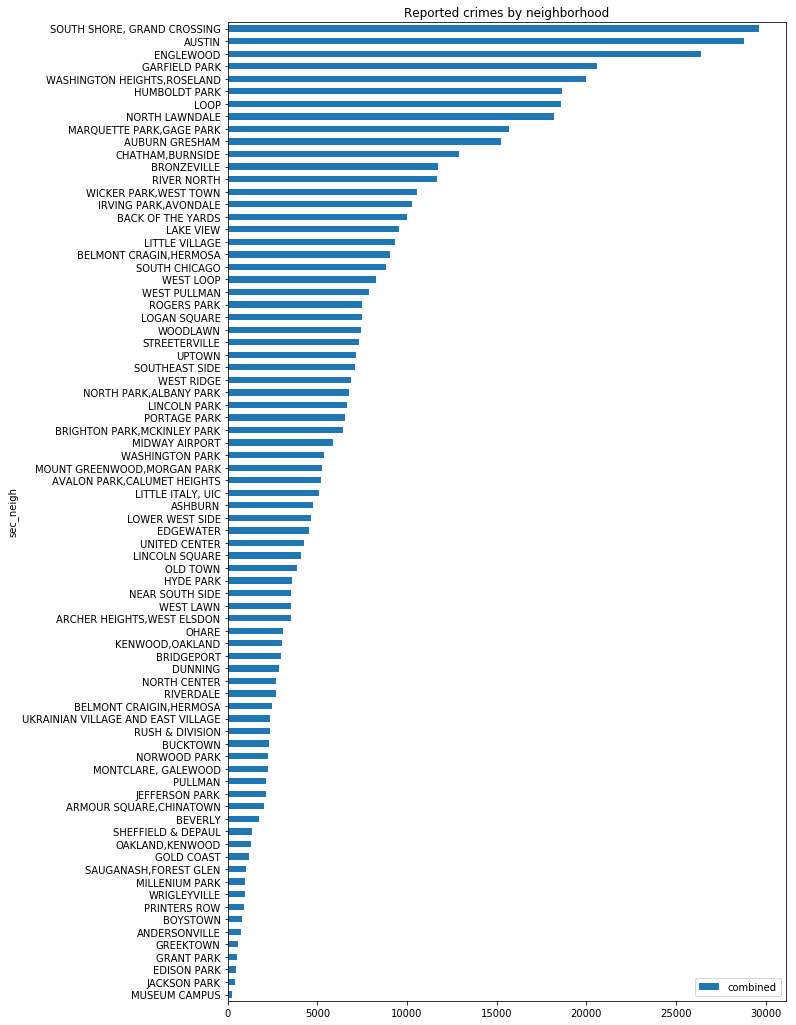

In [9]:
# Create figure for combined crimes by neighborhood
by_neighborhood = by_neighborhood.sort_values(by=['combined'])
by_neighborhood.plot.barh(x='sec_neigh', y='combined', figsize=(10, 18), 
                         title='Reported crimes by neighborhood')

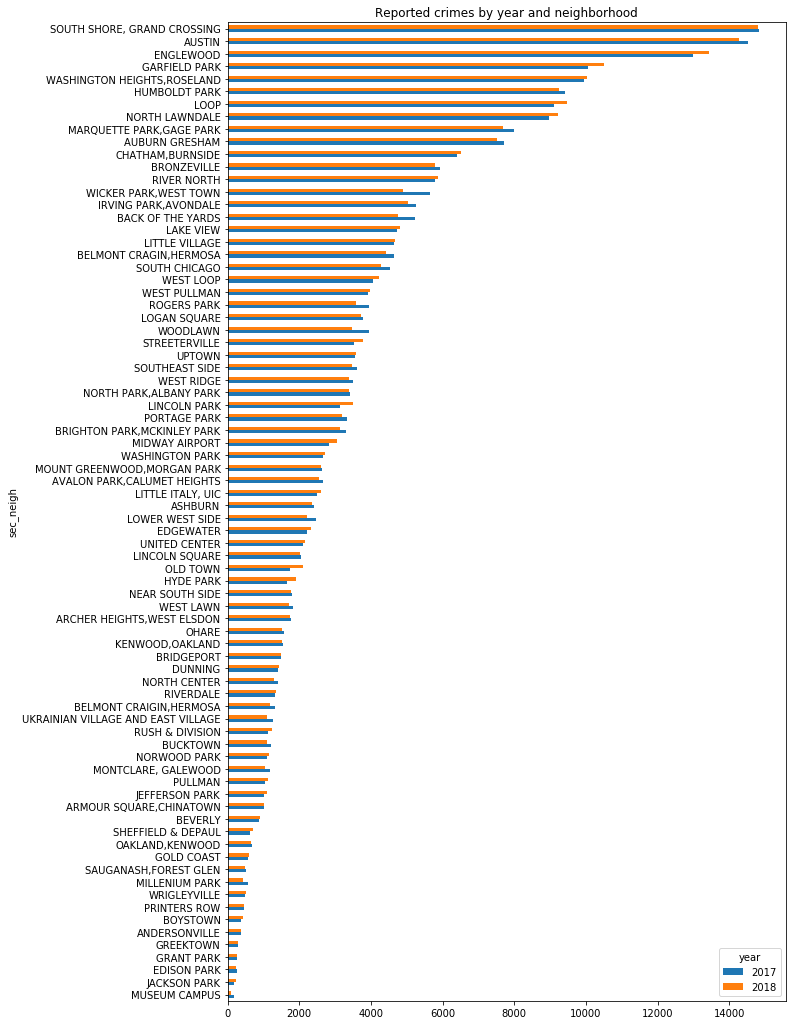

In [10]:
# Create figure for crimes by neighborhood for each year
by_neighborhood = by_neighborhood.sort_values(by=['combined'])
by_neighborhood.plot.barh(x='sec_neigh', y=['2017', '2018'], figsize=(10, 18), 
                         title='Reported crimes by year and neighborhood')

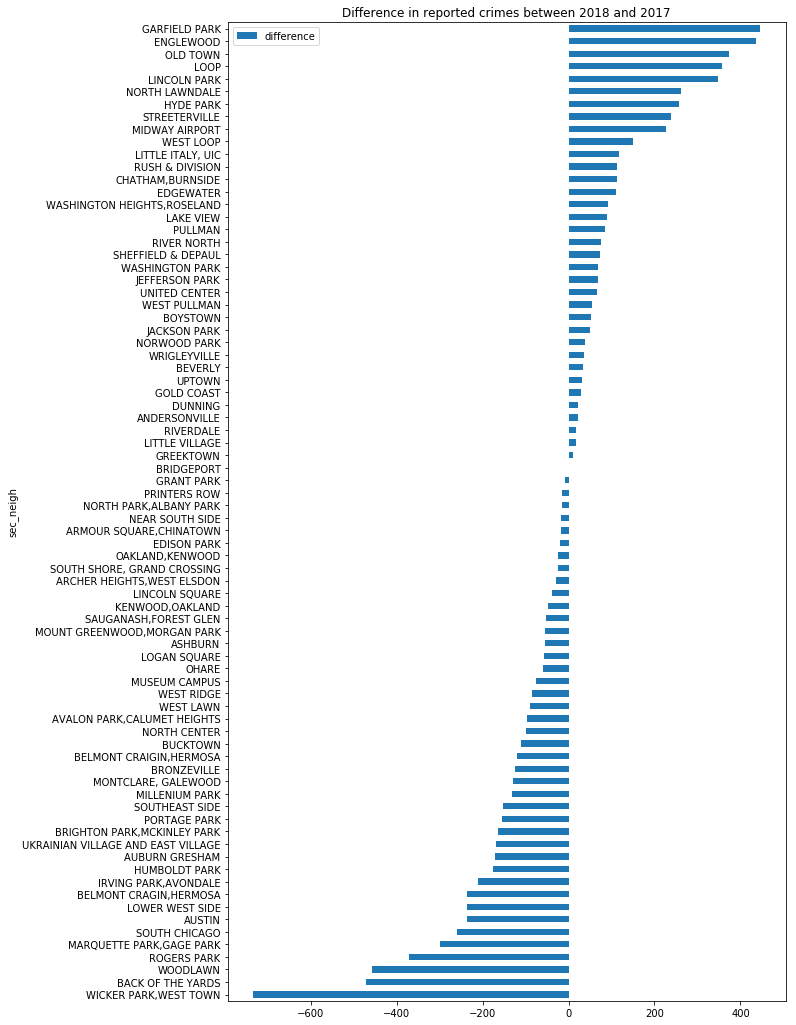

In [11]:
# Create figure for change (2018-2017) by neighborhood
by_neighborhood = by_neighborhood.sort_values(by=['difference'])
by_neighborhood.plot.barh(x='sec_neigh', y='difference', figsize=(10, 18), 
                 title='Difference in reported crimes between 2018 and 2017')

## Problem 2: Data Augmentation and APIs
This section combines the crime reports data from above with demographic data from the American Community Survey. Specifically, it incorporates data on the number of black and white individuals within the 'block group' where the crime was reported, along with the median income in that group. 

In [12]:
# Load census block geodata 
warnings.simplefilter(action='ignore', category=UserWarning)
url = 'https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999'
census_gdf = gpd.read_file(url)

# Join crime and census block geodata 
crime_neighborhood.drop(['index_right'], axis=1, inplace=True)
crime_neighborhood.crs = census_gdf.crs
crime_block = gpd.sjoin(crime_neighborhood, census_gdf, how="left", op='within')
crime_block['geo_12'] = crime_block['geoid10'].map(lambda x: str(x)[:12])

# Load ACS data 
acs_df = censusdata.download('acs5', 2015, censusdata.censusgeo([('state', '17'), ('county', '031'), ('block group', '*')]),
                    ['B02001_001E', 'B02001_002E', 'B02001_003E', 'B19013_001E', 'GEO_ID'])
acs_df = acs_df.rename(columns={acs_df.columns[0]: "total", 
                                acs_df.columns[1]: "white", 
                                acs_df.columns[2]: "black", 
                                acs_df.columns[3]: "median_income"})

# Clean ACS data 
acs_df['geo_12'] = acs_df['GEO_ID'].map(lambda x: str(x)[-12:])
acs_df = acs_df[['geo_12', 'total', 'white', 'black', 'median_income']].reset_index(drop=True)
acs_df = acs_df.astype(str)
acs_df.drop(acs_df[acs_df['median_income'].isin(['nan', '-666666666.0'])].index, inplace=True)
acs_df[['total', 'white', 'black', 'median_income']] = acs_df[['total', 'white', 'black', 'median_income']].apply(pd.to_numeric) 
acs_df['pct_white'] = acs_df['white'] / acs_df['total']
acs_df['pct_black'] = acs_df['black'] / acs_df['total']

In [13]:
# Reformat crime data 
pd.set_option('mode.chained_assignment', None)
by_block = crime_block.groupby(['geo_12', 'primary_type', 'year']).size()
by_block = by_block.unstack(fill_value=0)
by_block['combined'] = by_block['2017'] + by_block['2018']
by_block = by_block.unstack(fill_value=0)

# Join crime and ACS data (at block group level)
block_acs = pd.merge(by_block, acs_df, left_index=True, on='geo_12', how='left')
block_acs = block_acs.reset_index(drop=True)

In [14]:
# Function to subset data for a specific type of crime 
def block_acs_subset(primary_type):
    subset = block_acs[['geo_12', ('2017', primary_type), ('2018', primary_type), ('combined', primary_type), 
                    'total', 'white', 'black', 'median_income', 'pct_white', 'pct_black']] 
    subset['2017_rate'] = subset[('2017', primary_type)] / subset['total'] 
    subset['2018_rate'] = subset[('2018', primary_type)] / subset['total']
    subset['combined_rate'] = subset[('combined', primary_type)] / subset['total']
    return subset 

# Function to create figures for a type of crime across ACS indicators 
def block_acs_fig(primary_type, acs_var): 
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,5))
    primary_type.plot.scatter(x=acs_var, y="combined_rate", ax=ax1)
    primary_type.plot.scatter(x=acs_var, y="2018_rate", ax=ax2)
    primary_type.plot.scatter(x=acs_var, y="2017_rate", ax=ax3)
    for ax in [ax1, ax2, ax3]: 
        ax.set_ylim(bottom=0)
        ax.set_xlim(0)
    plt.show()

Incorporating the block-level data from the American Community Survey, the following scatterplots provide insight into the demographics of blocks based on their number of reported batteries. Rather than reporting the number of reported crimes, this data is normalized to a rate by dividing by the number of individuals living in that block group. This facilitates a more direct comparison of reported crines across blocks. 

From left to right, the three adjacent scatterplots in each panel show the combined rate of the relevant crime, the 2018 rate, and the 2017 rate plotted against the relevant demographic characteristic (with each dot representing a single block).  

### Question 1: What types of blocks have reports of “Battery”?
The following scatterplots show the rate of reported batteries against the proportion of white residents, proportion of black residents, and median income (in the three rows, respectively). The plots show that blocks with lower proportions of white residents, higher proportions of black residents, and lower median incomes tend to have more reported batteries.

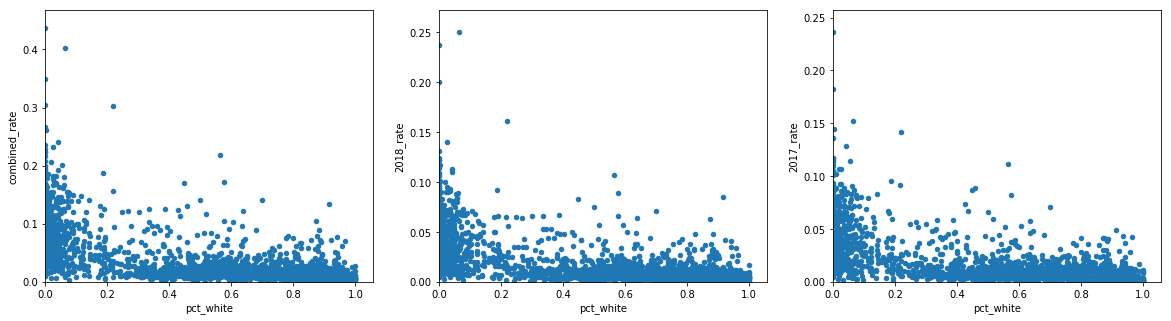

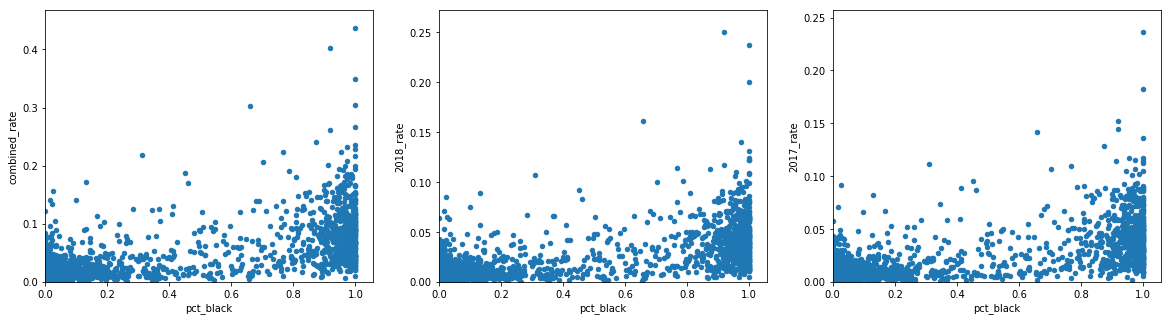

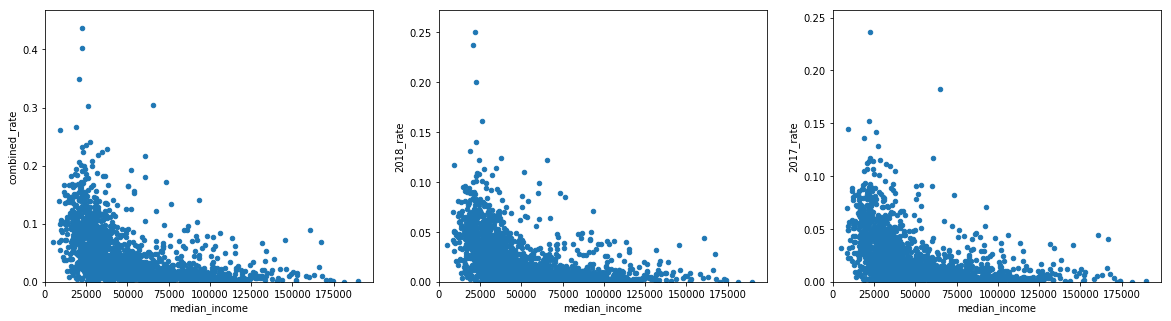

In [15]:
# Create battery figures 
battery = block_acs_subset('BATTERY')
block_acs_fig(battery, 'pct_white')
block_acs_fig(battery, 'pct_black')
block_acs_fig(battery, 'median_income')

### Question 2: What types of blocks get “Homicide”?
The following scatterplots parallel the above set– but show reports of homicides (rather than batteries) plotted against the block-level demographic data. As with batteries above, blocks with lower proportions of white residents, higher proportions of black residents, and lower median incomes tend to have more reported homicides. Given that there are substantively fewer homicides than batteries in the dataset, this trend is slightly less procured. 

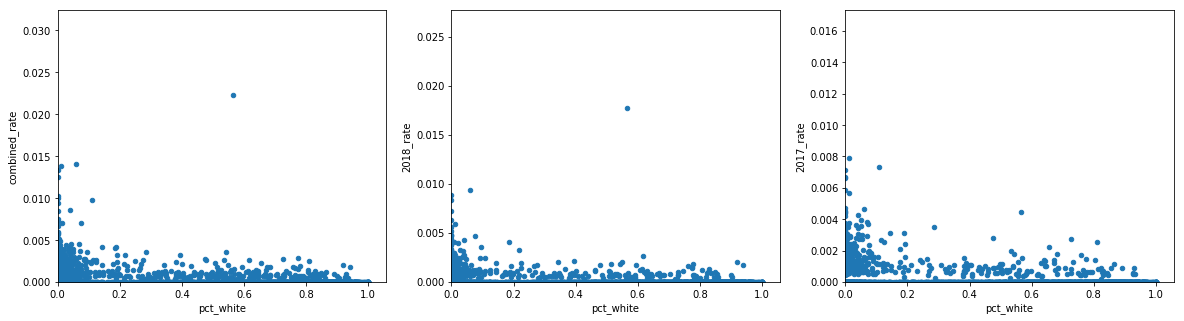

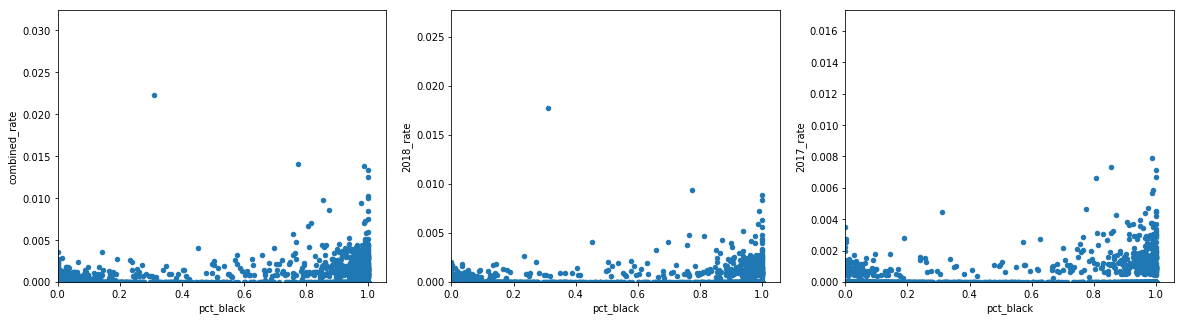

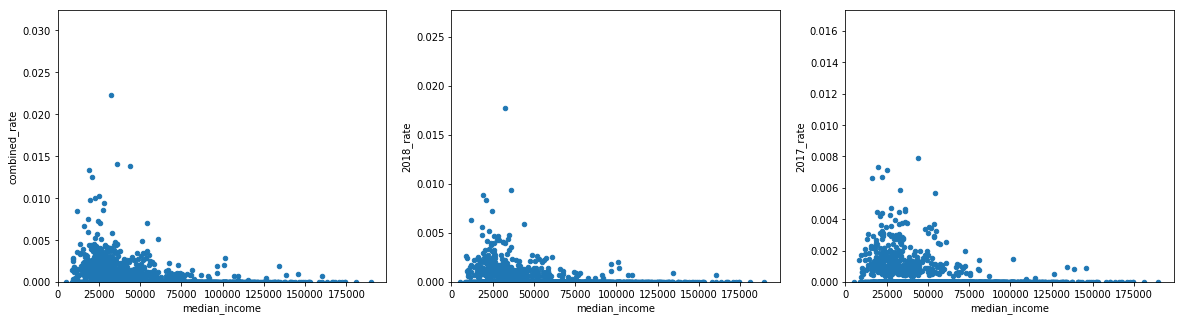

In [16]:
# Create homicide figures 
homicide = block_acs_subset('HOMICIDE')
block_acs_fig(homicide, 'pct_white')
block_acs_fig(homicide, 'pct_black')
block_acs_fig(homicide, 'median_income')

### Question 3: Does that change over time in the data you collected?
As shown by comparing the three adjacent scatterplots in each panel (which show the combined rate of crimes, the rate for 2018, and the rate for 2017, from left to right), there appear to be negligible differences in the above findings between 2017 and 2018. 

### Question 4: What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?
The scatterplots below are similar to those above, except in each row, the left plot shows the combined (including 2017 and 2018) number of sex offense reports per block (against the relevant democraphic indicator), while the right plot shows the combined number of deceptive practice reports per block. 

The most notable distinction is that there are substantially more deceptive practice reports than sex offense reports in aggregate. As shown in Problem 1, deceptive practice is the fifth most common type of crime in the dataset, while sex offense is the 17th most common. As a result, most blocks have fewer than 10 reports of sex offense– which makes discerning broader trends more difficult. Beyond further drawing attention to this difference in scale, the scatterplots don't reveal other obvious differences between blocks with reports of deceptive practice vs. blocks with reports of sex offense across the three demographic indicators. 

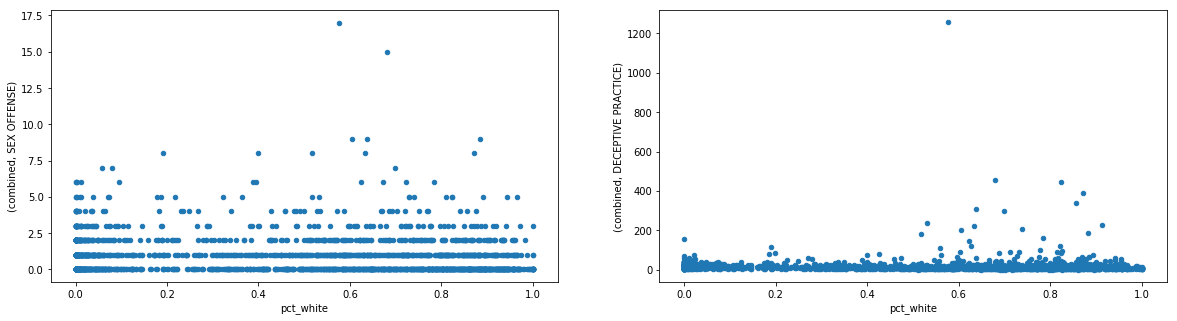

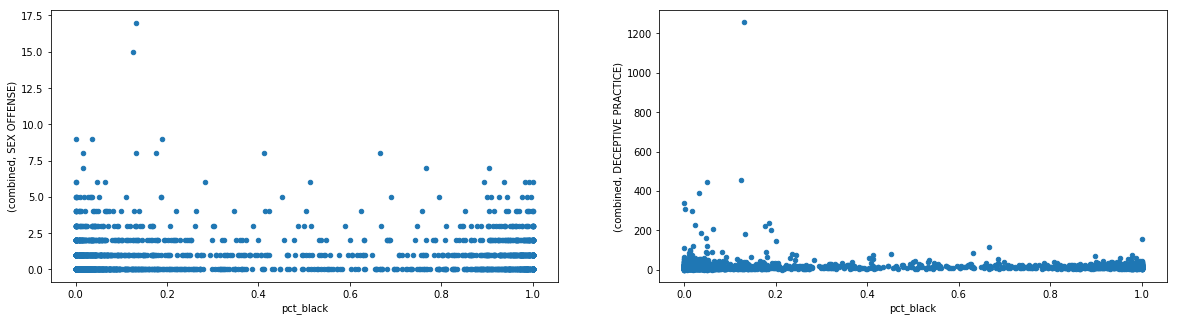

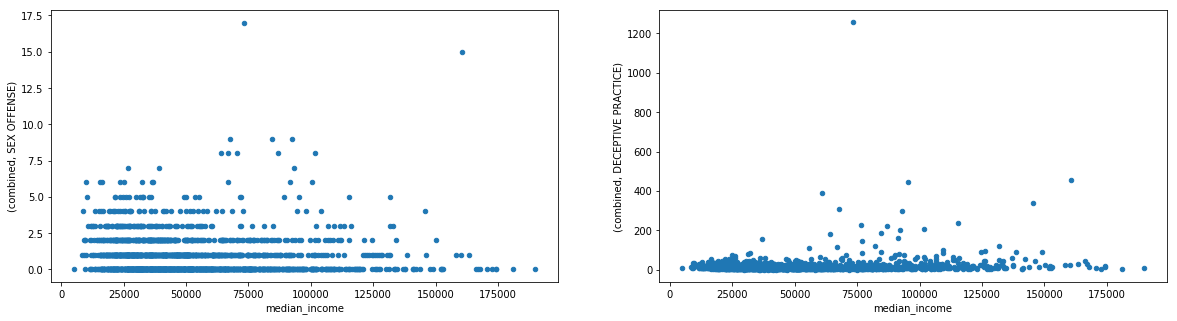

In [17]:
# Create figures comparing deceptive practice vs. sex offense 
deceptive_practice = block_acs_subset('DECEPTIVE PRACTICE')
sex_offense = block_acs_subset('SEX OFFENSE')    

for acs_var in ['pct_white', 'pct_black', 'median_income']: 
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5))
    sex_offense.plot.scatter(x=acs_var, y=('combined', 'SEX OFFENSE'), ax=ax1)
    deceptive_practice.plot.scatter(x=acs_var, y=('combined', 'DECEPTIVE PRACTICE'), ax=ax2)
    plt.show()

## Problem 3: Analysis and Communication

### Question 1: Describe how crime has changed in Chicago from 2017 to 2018?
In aggregate, crime reports marginally fell in Chicago between 2017 and 2018 by around 0.6%. More specifically, reported crimes fell from around 268,000 in 2017 to around 266,000 in 2018. 

Reproducing figures from the first problem in terms of percentage change, however, shows that this differed widely across neighborhoods and across types of crimes. Some neighborhoods (i.e., Jackson Park and Old Town) saw increases in reported crimes by more than 20%, while other neighborhoods saw dramatic decreases (e.g., Museum Campus). Additionally, the percentage change in concealed carry license violations, for example, skyrocketed by over 100%, while reports for other narcotic violations fell by nearly 100%. Thus, evaluating the overall change in crime between 2017 and 2018 is complicated. 

In [18]:
crime_df['year'].value_counts()

2017    268096
2018    266278
Name: year, dtype: int64

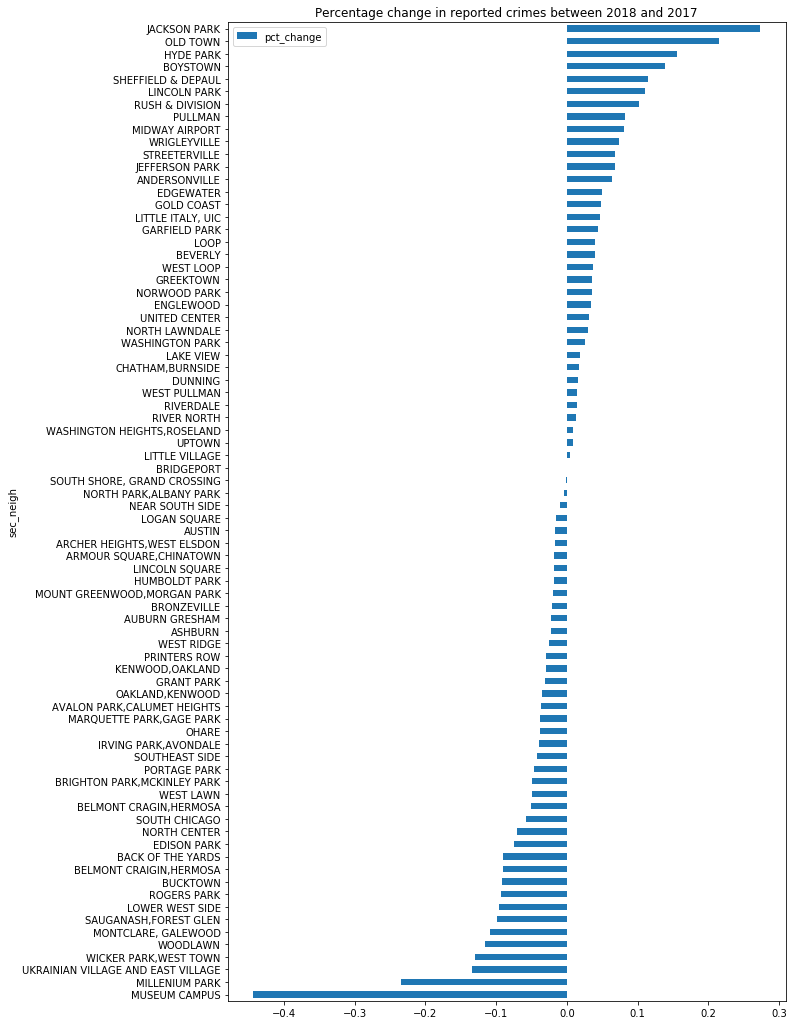

In [19]:
# Create figure for pct_change (2018-2017) by neighborhood
by_neighborhood = by_neighborhood.sort_values(by=['pct_change'])
by_neighborhood.plot.barh(x='sec_neigh', y='pct_change', figsize=(10, 18), 
                 title='Percentage change in reported crimes between 2018 and 2017')

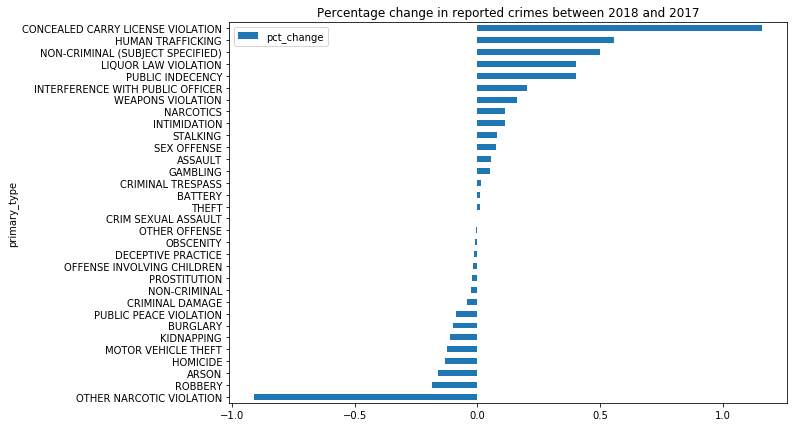

In [20]:
# Create figure for pct_change (2018-2017) by type of crime
by_type = by_type.sort_values(by=['pct_change'])
by_type.plot.barh(x='primary_type', y='pct_change', figsize=(10, 7), 
                 title='Percentage change in reported crimes between 2018 and 2017')

### Question 2
One of the alderman candidates from recent elections has some crime statistics on
his website: https://www.ringer4results.com/node/8 

Specifically:
 
Crime is a major issue in our neighborhoods over the last four years, and the data shows just that.
Let’s break down the Chicago Police Department’s report for the month leading up to July 26, 2018, compared to the same week in 2017:
- Robberies -- up 21 percent over the same time-frame in 2017
- Aggravated batteries -- up 136 percent
- Burglaries -- an increase of 50 percent
- Motor vehicle theft -- up 41 percent.

All told, crime rose 16 percent in the same 28-day time period in just one year. But take a look at the year-to-date number and you’ll see how crime has affected our local neighborhoods in a four-year period:
- Rose 10 percent since 2017
- Rose 22 percent since 2016

#### A. Are these statistics correct? 
The following tables reproduce the alderman's statistics. 
First, comparing the 28 days leading up to July 26, 2018 to that period in the previous year, the total number of reported robberies fell by around 10%, batteries rose by around 8%, burglaries fell by around 7%, and motor vehicles thefts fell by around 15%. The overall increase in all types of reported crime was around 2% across these two time periods. This breakdown is shown in the table below.

In [21]:
def pct_change_by_type(df): 
    by_type = df.groupby(['primary_type', 'year']).size().unstack(fill_value=0)
    by_type['difference'] = by_type['2018'] - by_type['2017']
    by_type['pct_change'] = (by_type['difference']) / by_type['2017']
    sample_change = (by_type['2018'].sum() - by_type['2017'].sum()) / by_type['2017'].sum() 
    print('ALL CRIMES PCT_CHANGE:', sample_change.round(5))
    return by_type

In [22]:
# Comparing 28 days before July 26, 2018 to 28 days before July 26, 2017
crime_sample = crime_df[((crime_df['date'] < '2018-07-26') 
                       & (crime_df['date'] > '2018-06-28')) 
                       | ((crime_df['date'] < '2017-07-26') 
                       & (crime_df['date'] > '2017-06-28'))]
pct_change_by_type(crime_sample).loc[['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']] 

ALL CRIMES PCT_CHANGE: 0.02264


year,2017,2018,difference,pct_change
primary_type,,,,
ROBBERY,907,813,-94,-0.103638
BATTERY,4161,4504,343,0.082432
BURGLARY,1101,1023,-78,-0.070845
MOTOR VEHICLE THEFT,909,769,-140,-0.154015


When just considering the 43rd ward (where the alderman was running), robberies, batteries, and burglaries all fell across the periods, and the overall increase was around 11.5%, not 16%– as shown in the table below. 

In [23]:
# Comparing 28 days before July 26, 2018 to 28 days before July 26, 2017 in Ward 43
crime_sample_ward43 = crime_sample[crime_sample['ward']=='43']
pct_change_by_type(crime_sample_ward43).loc[['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']] 

ALL CRIMES PCT_CHANGE: 0.11504


year,2017,2018,difference,pct_change
primary_type,,,,
ROBBERY,17,8,-9,-0.529412
BATTERY,38,33,-5,-0.131579
BURGLARY,16,13,-3,-0.187500
MOTOR VEHICLE THEFT,5,10,5,1.000000


The alderman's claim of the 'year-to-date' through July 26 rise is also reproduced below. Comparing this time period in 2018 to its counterpart in 2017, total crime reports actually fell by slightly over 1%. 

In [24]:
# Comparing year-to-date through July 26, 2018 and through July 26, 2017
crime_sample2 = crime_df[((crime_df['date'] < '2018-07-26') 
                        & (crime_df['date'] >= '2018-01-01')) 
                        | ((crime_df['date'] < '2017-07-26') 
                        & (crime_df['date'] >= '2017-01-01'))]
pct_change_by_type(crime_sample2).loc[['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']] 

ALL CRIMES PCT_CHANGE: -0.01174


year,2017,2018,difference,pct_change
primary_type,,,,
ROBBERY,6195,5332,-863,-0.139306
BATTERY,27920,28170,250,0.008954
BURGLARY,7315,6368,-947,-0.129460
MOTOR VEHICLE THEFT,6330,5447,-883,-0.139494


In the alderman's 43rd district, however, crime reports rose by around 9% across these periods– although this is still substantively lower than his claim. 

In [25]:
# Comparing 28 days before July 26, 2018 to 28 days before July 26, 2017 in Ward 43
crime_sample_ward43_2 = crime_sample2[crime_sample2['ward']=='43']
pct_change_by_type(crime_sample_ward43_2).loc[['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']] 

ALL CRIMES PCT_CHANGE: 0.09921


year,2017,2018,difference,pct_change
primary_type,,,,
ROBBERY,71,73,2,0.028169
BATTERY,212,192,-20,-0.094340
BURGLARY,82,86,4,0.048780
MOTOR VEHICLE THEFT,75,73,-2,-0.026667


#### B. Could they be misleading or would you agree with the conclusions he’s drawing? Why or why not?
As shown above, my reproduced versions of the alderman's statistics differ from his. Additionally, I would generally disagree with his methodology and broader conclusions. 

The table below shows the change in crime reports for the same four types of crimes that he identified across all of the two years. Here, it's clear that reported robberies, burglaries, and motor vehicle thefts all fell from 2017 to 2018. Reported batteries rose, but only by around 1%. The overall number of reported crimes fell marginally by 0.6% between 2017 and 2018. 

In [26]:
# Comparing all of 2017 to 2018 
pct_change_by_type(crime_df).loc[['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']] 

ALL CRIMES PCT_CHANGE: -0.00678


year,2017,2018,difference,pct_change
primary_type,,,,
ROBBERY,11877,9682,-2195,-0.184811
BATTERY,49214,49781,567,0.011521
BURGLARY,13000,11730,-1270,-0.097692
MOTOR VEHICLE THEFT,11406,9988,-1418,-0.124321


In the alderman's 43rd district, reported robberies, batteries, and motor vehicle thefts also fell, although burglaries rose by around 12% from 2017 to 2018. The overall number of reported crimes rose by around 7.5%. 

In [27]:
# Comparing all of 2017 to 2018 for Ward 43
ward_43 = crime_df[crime_df['ward']=='43']
pct_change_by_type(ward_43).loc[['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']] 

ALL CRIMES PCT_CHANGE: 0.07508


year,2017,2018,difference,pct_change
primary_type,,,,
ROBBERY,140,136,-4,-0.028571
BATTERY,359,342,-17,-0.047354
BURGLARY,166,186,20,0.120482
MOTOR VEHICLE THEFT,162,139,-23,-0.141975


### Question 3
As you know, there will be a new mayor in Chicago very soon. Based on these summary statistics, provide 5 key findings to the new mayor’s office about crime in Chicago and what they should focus on in order to deal with crime in Chicago.

1. As shown above and in Problem 1, reported crimes (and changes in reported crimes) vary tremendously across neighborhoods. Specifically, allocating resources towards neighborhoods that have seen recent increases in crime reports (e.g., Garfield Park, Englewood, Old Town, as shown in Problem 1) would be beneficial. 
2. Similarly, reported crimes vary tremendously across the type of crime. Between 2017 and 2018, the number of crimes involving narcotics and assaults increased more than any other type– allocating resources to target these types of crimes would also be beneficial. 
3. As shown in Problem 2, crime reports are more prevelant on blocks with higher black populations and lower median incomes. Thus, broader efforts to promote education and economic opportunities in these communities would also promote crime reduction efforts. 
4. Given that violent crimes are likely more urgent than non-violent crimes, the substantive increase in the number of assaults between 2017 and 2018 should potentially be of concern. 
5. Given the seasonal nature of crime (with more crimes in warmer weather, as shown in the figure below), resources should be deployed with consideration to cyclical trends. 

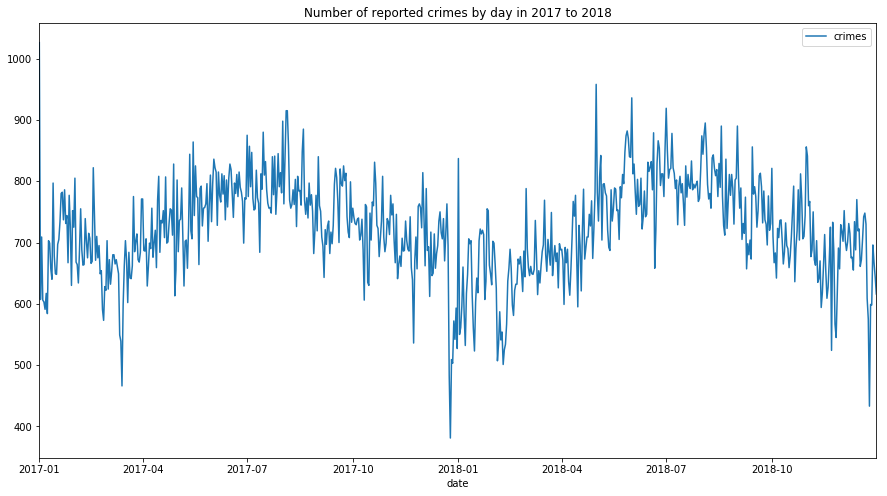

In [28]:
# Figure showing daily crimes over time 
crime_neighborhood['just_date'] = pd.to_datetime(crime_neighborhood['date']).dt.date
by_date = crime_neighborhood['just_date'].value_counts().to_frame().reset_index()
by_date.columns = ['date', 'crimes']

by_date.plot.line(x='date', y='crimes', figsize=(15,8), 
                  title='Number of reported crimes by day in 2017 to 2018')

### Question 4
What are some of the key caveats of your recommendations and limitations of the analysis that you just did?
1. The American Community Survey data is aggregated at the block group level (of which there are over 2,000 in the crime data). Thus, this analysis can show trends between the demographics of a block and the crimes reported on that block– but not the demographics of the individuals directly involved in that crime. This data doesn't allow for an analysis of, for example, racial bias in stops. 
2. The demographic data from the American Community Survey is several years old (from 2015), and block-level demographics in several parts of Chicago are substantively different than they were in 2015. 
3. The data and subsequent analysis reflects reported crimes– which is a different metric than all crimes. Specifically, certain groups or communities may be less likely to report crimes (influenced by, for example, their relationships with police, the criminal justice system, etc.). 

## Problem 4: Probabilities
Assume you are running the 911 call center for Chicago. You get a call from someone at 2111 S Michigan Ave:
###  A 
Of the types of crimes you have data for, which crime type is the most likely given the call came from 2111 S Michigan Ave? What are the probabilities for each type of request?

The most likely crime given that the call came fom 2111 S Michican Ave is battery. The probabilities for each type of request is shown in the table below. 

In [29]:
# Problem 4A 
s_mich_2111 = crime_neighborhood[crime_neighborhood['block']=='021XX S MICHIGAN AVE']
s_mich_2111 = s_mich_2111['primary_type'].value_counts().to_frame().reset_index()
s_mich_2111.columns = ['primary_type', 'count']
s_mich_2111['pct'] = s_mich_2111['count'] / s_mich_2111['count'].sum()
s_mich_2111

,primary_type,count,pct
0,BATTERY,16,0.271186
1,OTHER OFFENSE,12,0.203390
2,THEFT,6,0.101695
3,DECEPTIVE PRACTICE,6,0.101695
4,ASSAULT,6,0.101695
5,CRIMINAL DAMAGE,6,0.101695
6,ROBBERY,2,0.033898
7,MOTOR VEHICLE THEFT,2,0.033898
8,PUBLIC PEACE VIOLATION,1,0.016949
9,CRIMINAL TRESPASS,1,0.016949


### B
Let’s now assume that a call comes in about Theft. Which is more likely– that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park vs Uptown?

The conditional probability that the call came from Garfield Park given that it was about theft is 0.0196. The conditional probability that the call was from Uptown given that it was about theft is 0.0154. Thus, it is 0.0042 (or 0.42%) more likely that the call came from Garfield Park vs. Uptown. 

In [30]:
# Problem 4B
theft = crime_neighborhood[crime_neighborhood['primary_type']=='THEFT']
theft = theft['sec_neigh'].value_counts().to_frame().reset_index()
theft.columns = ['sec_neigh', 'count']
theft['pct'] = theft['count'] / theft['count'].sum()
theft.loc[theft['sec_neigh'].isin(['GARFIELD PARK', 'UPTOWN'])]

,sec_neigh,count,pct
17,GARFIELD PARK,2493,0.019617
20,UPTOWN,1956,0.015391


### C
Now assume that you don’t have access to all the raw data and you know the following things:
There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown. Of the 600 calls from Garfield Park, 100 of them are about Battery. Of the 400 calls from Uptown, 160 are about Battery. If a call comes about Battery, how much more/less likely is it that the call came from Garfield Park versus Uptown?

The conditional probability that the call was from Garfield Park given that it was about a battery is $\frac{100}{260}$. The conditional probability that the call was from Uptown given that it was about a battery is $\frac{160}{260}$. Thus, the difference is $\frac{100}{260}-\frac{160}{260}=-0.23$, meaning it is 23% less likely that the call came from Garfield Park vs. Uptown. 

In [31]:
# Problem 4C
data = [('Garfield Park', 100, 500), ('Uptown', 160, 240)]
labels = ['neighborhood', 'battery', 'other']
df = pd.DataFrame.from_records(data, columns=labels)
df['pct'] = df['battery'] / df['battery'].sum()
df

,neighborhood,battery,other,pct
0,Garfield Park,100,500,0.384615
1,Uptown,160,240,0.615385
